<a href="https://colab.research.google.com/github/gibsonx/AnsibleGUI/blob/master/skeleton_detection_full_points.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
tf.__version__
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

1.13.1+cu116 True


In [3]:
!pip show pyyaml
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git' &> /dev/null

Name: PyYAML
Version: 6.0
Summary: YAML parser and emitter for Python
Home-page: https://pyyaml.org/
Author: Kirill Simonov
Author-email: xi@resolvent.net
License: MIT
Location: /usr/local/lib/python3.8/dist-packages
Requires: 
Required-by: albumentations, bokeh, dask, distributed, fastai, PyDrive


In [4]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
#from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer,ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

In [19]:
from detectron2.data.datasets import register_coco_instances

register_coco_instances("person_keypoints_train", {}, "/content/drive/MyDrive/Dataset/annotations/person_keypoints_val2017.json", "/content/drive/MyDrive/Dataset/val2017")

In [18]:
#MetadataCatalog.remove("person_keypoints_train")
#DatasetCatalog.remove("person_keypoints_train")

In [20]:
keypoint_names = ['nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear', 'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow', 'left_wrist', 'right_wrist', 'left_hip', 'right_hip', 'left_knee', 'right_knee', 'left_ankle', 'right_ankle']
keypoint_flip_map = [('left_eye', 'right_eye'),('left_ear', 'right_ear'),('left_shoulder', 'right_shoulder'),('left_elbow', 'right_elbow'),('left_wrist', 'right_wrist'),('left_hip', 'right_hip'),('left_knee', 'right_knee'),('left_ankle', 'right_ankle')]
keypoint_connection_rules = [('left_ear', 'left_eye', (102, 204, 255)), ('right_ear', 'right_eye', (51, 153, 255)), ('left_eye', 'nose', (102, 0, 204)), ('nose', 'right_eye', (51, 102, 255)), ('left_shoulder', 'right_shoulder', (255, 128, 0)), ('left_shoulder', 'left_elbow', (153, 255, 204)), ('right_shoulder', 'right_elbow', (128, 229, 255)), ('left_elbow', 'left_wrist', (153, 255, 153)), ('right_elbow', 'right_wrist', (102, 255, 224)), ('left_hip', 'right_hip', (255, 102, 0)), ('left_hip', 'left_knee', (255, 255, 77)), ('right_hip', 'right_knee', (153, 255, 204)), ('left_knee', 'left_ankle', (191, 255, 128)), ('right_knee', 'right_ankle', (255, 195, 77))]

In [25]:
from detectron2.data import MetadataCatalog
MetadataCatalog.get("person_keypoints_train").keypoint_connection_rules = keypoint_connection_rules
MetadataCatalog.get("person_keypoints_train").thing_classes = ["person"]
MetadataCatalog.get("person_keypoints_train").thing_dataset_id_to_contiguous_id = {1:0}
MetadataCatalog.get("person_keypoints_train").keypoint_names = keypoint_names
MetadataCatalog.get("person_keypoints_train").keypoint_flip_map = keypoint_flip_map
MetadataCatalog.get("person_keypoints_train").evaluator_type="coco"

In [28]:
person_metadata = MetadataCatalog.get("person_keypoints_train")
person_metadata

Metadata(evaluator_type='coco', image_root='/content/drive/MyDrive/Dataset/val2017', json_file='/content/drive/MyDrive/Dataset/annotations/person_keypoints_val2017.json', keypoint_connection_rules=[('left_ear', 'left_eye', (102, 204, 255)), ('right_ear', 'right_eye', (51, 153, 255)), ('left_eye', 'nose', (102, 0, 204)), ('nose', 'right_eye', (51, 102, 255)), ('left_shoulder', 'right_shoulder', (255, 128, 0)), ('left_shoulder', 'left_elbow', (153, 255, 204)), ('right_shoulder', 'right_elbow', (128, 229, 255)), ('left_elbow', 'left_wrist', (153, 255, 153)), ('right_elbow', 'right_wrist', (102, 255, 224)), ('left_hip', 'right_hip', (255, 102, 0)), ('left_hip', 'left_knee', (255, 255, 77)), ('right_hip', 'right_knee', (153, 255, 204)), ('left_knee', 'left_ankle', (191, 255, 128)), ('right_knee', 'right_ankle', (255, 195, 77))], keypoint_flip_map=[('left_eye', 'right_eye'), ('left_ear', 'right_ear'), ('left_shoulder', 'right_shoulder'), ('left_elbow', 'right_elbow'), ('left_wrist', 'right_w

In [24]:
dataset_dicts = DatasetCatalog.get("person_keypoints_train")
dataset_dicts[0]

[02/19 04:23:36 d2.data.datasets.coco]: Loaded 5000 images in COCO format from /content/drive/MyDrive/Dataset/annotations/person_keypoints_val2017.json


{'file_name': '/content/drive/MyDrive/Dataset/val2017/000000000139.jpg',
 'height': 426,
 'width': 640,
 'image_id': 139,
 'annotations': [{'iscrowd': 0,
   'bbox': [412.8, 157.61, 53.05, 138.01],
   'keypoints': [427.5,
    170.5,
    1,
    429.5,
    169.5,
    2,
    0.5,
    0.5,
    0,
    434.5,
    168.5,
    2,
    0.5,
    0.5,
    0,
    441.5,
    177.5,
    2,
    446.5,
    177.5,
    2,
    437.5,
    200.5,
    2,
    430.5,
    206.5,
    2,
    430.5,
    220.5,
    2,
    420.5,
    215.5,
    2,
    445.5,
    226.5,
    2,
    452.5,
    223.5,
    2,
    447.5,
    260.5,
    2,
    454.5,
    257.5,
    2,
    455.5,
    290.5,
    2,
    459.5,
    286.5,
    2],
   'category_id': 0,
   'segmentation': [[428.19,
     219.47,
     430.94,
     209.57,
     430.39,
     210.12,
     421.32,
     216.17,
     412.8,
     217.27,
     413.9,
     214.24,
     422.42,
     211.22,
     429.29,
     201.6,
     430.67,
     181.8,
     430.12,
     175.2,
     427.09,

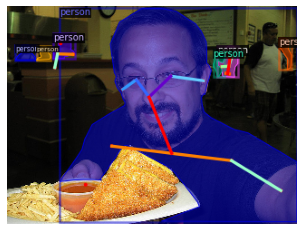

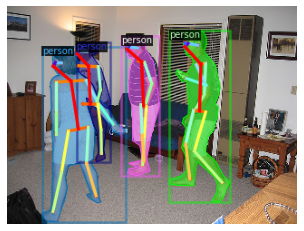

In [26]:
# To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the dataset:
import random
from detectron2.utils.visualizer import Visualizer

hands_metadata = MetadataCatalog.get("person_keypoints_train")

def cv2_imshow(im):
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.figure(), plt.imshow(im), plt.axis('off');

for d in random.sample(dataset_dicts, 2):
  img = cv2.imread(d["file_name"])
  visualizer = Visualizer(img[:, :, ::-1], metadata=hands_metadata, scale=0.5)    
  vis = visualizer.draw_dataset_dict(d)
  cv2_imshow(vis.get_image()[:, :, ::-1])

In [106]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
# cfg.MODEL.DEVICE = "cpu"


cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("person_keypoints_train",)


#cfg.DATASETS.TEST = ("hand_test",)  #Dataset 'hand_test' is empty in my case
cfg.DATASETS.TEST = ()

cfg.DATALOADER.NUM_WORKERS = 2
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final_train.pth")

cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 2000   # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   #128   # faster, and good enough for this toy dataset (default: 512)

cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # person
cfg.MODEL.RETINANET.NUM_CLASSES = 1
cfg.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = 17
cfg.TEST.KEYPOINT_OKS_SIGMAS = np.ones((17, 1), dtype=float).tolist()


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)    #CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[02/19 05:44:50 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.keypoint_head.conv_fcn1.{bias, weight}
roi_heads.keypoint_head.conv_fcn2.{bias, weight}
roi_heads.keypoint_head.conv_fcn3.{bias, weight}
roi_heads.keypoint_head.conv_fcn4.{bias, weight}
roi_heads.keypoint_head.conv_fcn5.{bias, weight}
roi_heads.keypoint_head.conv_fcn6.{bias, weight}
roi_heads.keypoint_head.conv_fcn7.{bias, weight}
roi_heads.keypoint_head.c

[02/19 05:44:51 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.8/dist-packages/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)
/usr/local/lib/python3.8/dist-packages/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)


[02/19 05:45:01 d2.utils.events]:  eta: 0:15:18  iter: 19  total_loss: 9.402  loss_cls: 0.4351  loss_box_reg: 0.05528  loss_keypoint: 8.118  loss_rpn_cls: 0.6937  loss_rpn_loc: 0.0511  time: 0.4559  last_time: 0.5046  data_time: 0.0266  last_data_time: 0.0070   lr: 4.9953e-06  max_mem: 3395M
[02/19 05:45:10 d2.utils.events]:  eta: 0:14:58  iter: 39  total_loss: 9.23  loss_cls: 0.31  loss_box_reg: 0.05002  loss_keypoint: 8.14  loss_rpn_cls: 0.6863  loss_rpn_loc: 0.0409  time: 0.4531  last_time: 0.4029  data_time: 0.0170  last_data_time: 0.0209   lr: 9.9902e-06  max_mem: 3395M
[02/19 05:45:19 d2.utils.events]:  eta: 0:14:49  iter: 59  total_loss: 9.101  loss_cls: 0.1877  loss_box_reg: 0.0372  loss_keypoint: 8.115  loss_rpn_cls: 0.6675  loss_rpn_loc: 0.05405  time: 0.4544  last_time: 0.4751  data_time: 0.0129  last_data_time: 0.0070   lr: 1.4985e-05  max_mem: 3395M
[02/19 05:45:28 d2.utils.events]:  eta: 0:14:50  iter: 79  total_loss: 9.039  loss_cls: 0.1696  loss_box_reg: 0.05036  loss_k

[02/19 06:10:10 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


backbone.res2.0.conv1.norm.{bias, weight}
backbone.res2.0.conv1.weight
backbone.res2.0.conv2.norm.{bias, weight}
backbone.res2.0.conv2.weight
backbone.res2.0.conv3.norm.{bias, weight}
backbone.res2.0.conv3.weight
backbone.res2.0.shortcut.norm.{bias, weight}
backbone.res2.0.shortcut.weight
backbone.res2.1.conv1.norm.{bias, weight}
backbone.res2.1.conv1.weight
backbone.res2.1.conv2.norm.{bias, weight}
backbone.res2.1.conv2.weight
backbone.res2.1.conv3.norm.{bias, weight}
backbone.res2.1.conv3.weight
backbone.res2.2.conv1.norm.{bias, weight}
backbone.res2.2.conv1.weight
backbone.res2.2.conv2.norm.{bias, weight}
backbone.res2.2.conv2.weight
backbone.res2.2.conv3.norm.{bias, weight}
backbone.res2.2.conv3.weight
backbone.res3.0.conv1.norm.{bias, weight}
backbone.res3.0.conv1.weight
backbone.res3.0.conv2.norm.{bias, weight}
backbone.res3.0.conv2.weight
backbone.res3.0.conv3.norm.{bias, weight}
backbone.res3.0.conv3.weight
backbone.res3.0.shortcut.norm.{bias, weight}
backbone.res3.0.shortcut.w

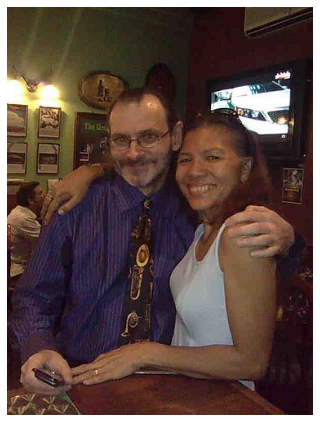

In [138]:
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

cfg = get_cfg()
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1

predictor = DefaultPredictor(cfg)
im = cv2.imread("/content/drive/MyDrive/Dataset/val2017/000000006763.jpg")
cv2_imshow(im)

In [140]:
outputs = predictor(im)
print(outputs["instances"])

Instances(num_instances=0, image_height=500, image_width=375, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64)])


In [132]:
list(outputs['instances'].pred_classes)

[tensor(29, device='cuda:0'), tensor(29, device='cuda:0')]

In [136]:
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer
v = Visualizer(im[:, :, ::-1],
  metadata=person_metadata, 
  scale=0.8, 
  instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
)


v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize = (14, 10))
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
plt.show()


# o = outputs["instances"]
# #Create new class, boxes, scores & masks
# classes = o.pred_classes[idxofClass]
# scores = o.scores[idxofClass]
# boxes = o.pred_boxes[idxofClass]
# #masks = o.pred_masks[idxofClass]

# #Define new instance and set the new values to new instance. Note: detectron2 module provides this method set.
# obj = detectron2.structures.Instances(image_size=(480, 640))

# obj.set('pred_classes', classes)
# obj.set('scores', scores)
# obj.set('pred_boxes', boxes)

# obj

IndexError: ignored